In [140]:
from email.headerregistry import AddressHeader
from cv2 import kmeans
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import mpl_toolkits.mplot3d as m3d
import matplotlib.pyplot as plt
from numpy import unique
from numpy import where
import math

class WavefrontGroup:
    def __init__(self, name='default'):
        self.name = name               # group name
        # vertices as an Nx3 or Nx6 array (per vtx colors)
        self.vertices = []
        self.normals = []                 # normals
        self.texcoords = []                 # texture coordinates
        # M*Nv*3 array, Nv=# of vertices, stored as vid,tid,nid (-1 for N/A)
        self.polygons = []


class WavefrontOBJ:
    def __init__(self, default_mtl='default_mtl'):
        self.path = None               # path of loaded object
        self.mtllibs = []                 # .mtl files references via mtllib
        self.mtls = [default_mtl]    # materials referenced
        self.mtlid = []                 # indices into self.mtls for each polygon
        # vertices as an Nx3 or Nx6 array (per vtx colors)
        self.vertices = []
        self.normals = []                 # normals
        self.texcoords = []                 # texture coordinates
        # M*Nv*3 array, Nv=# of vertices, stored as vid,tid,nid (-1 for N/A)
        self.polygons = []
        self.groups = []                 # Groups


def load_obj(filename: str, default_mtl='default_mtl', triangulate=False) -> WavefrontOBJ:
    """Reads a .obj file from disk and returns a WavefrontOBJ instance

    Handles only very rudimentary reading and contains no error handling!

    Does not handle:
        - relative indexing
        - subobjects or groups
        - lines, splines, beziers, etc.
    """
    # parses a vertex record as either vid, vid/tid, vid//nid or vid/tid/nid
    # and returns a 3-tuple where unparsed values are replaced with -1
    def parse_vertex(vstr):
        vals = vstr.split('/')
        vid = int(vals[0])-1
        tid = int(vals[1])-1 if len(vals) > 1 and vals[1] else -1
        nid = int(vals[2])-1 if len(vals) > 2 else -1
        return (vid, tid, nid)

    with open(filename, 'r') as objf:
        obj = WavefrontOBJ(default_mtl=default_mtl)
        obj.path = filename
        cur_mat = obj.mtls.index(default_mtl)
        cur_group = WavefrontGroup()

        for line in objf:
            toks = line.split()
            if not toks:
                continue
            if toks[0] == 'g':
                cur_group = WavefrontGroup(name=toks[1])
                obj.groups.append(cur_group)
            if toks[0] == 'v':
                cur_group.vertices.append([float(v) for v in toks[1:]])
            elif toks[0] == 'vn':
                cur_group.normals.append([float(v) for v in toks[1:]])
            elif toks[0] == 'vt':
                cur_group.texcoords.append([float(v) for v in toks[1:]])
            elif toks[0] == 'f':
                poly = [parse_vertex(vstr) for vstr in toks[1:]]
                if triangulate:
                    for i in range(2, len(poly)):
                        obj.mtlid.append(cur_mat)
                        cur_group.polygons.append(
                            (poly[0], poly[i-1], poly[i]))
                else:
                    obj.mtlid.append(cur_mat)
                    cur_group.polygons.append(poly)
            elif toks[0] == 'mtllib':
                obj.mtllibs.append(toks[1])
            elif toks[0] == 'usemtl':
                if toks[1] not in obj.mtls:
                    obj.mtls.append(toks[1])
                cur_mat = obj.mtls.index(toks[1])
        return obj


def save_obj(obj: WavefrontOBJ, filename: str):
    """Saves a WavefrontOBJ object to a file

    Warning: Contains no error checking!

    """
    with open(filename, 'w') as ofile:
        for mlib in obj.mtllibs:
            ofile.write('mtllib {}\n'.format(mlib))
        for vtx in obj.vertices:
            ofile.write('v '+' '.join(['{}'.format(v) for v in vtx])+'\n')
        for tex in obj.texcoords:
            ofile.write('vt '+' '.join(['{}'.format(vt) for vt in tex])+'\n')
        for nrm in obj.normals:
            ofile.write('vn '+' '.join(['{}'.format(vn) for vn in nrm])+'\n')
        if not obj.mtlid:
            obj.mtlid = [-1] * len(obj.polygons)
        poly_idx = np.argsort(np.array(obj.mtlid))
        cur_mat = -1
        for pid in poly_idx:
            if obj.mtlid[pid] != cur_mat:
                cur_mat = obj.mtlid[pid]
                ofile.write('usemtl {}\n'.format(obj.mtls[cur_mat]))
            pstr = 'f '
            for v in obj.polygons[pid]:
                # UGLY!
                vstr = '{}/{}/{} '.format(v[0]+1, v[1]+1 if v[1]
                                          >= 0 else 'X', v[2]+1 if v[2] >= 0 else 'X')
                vstr = vstr.replace('/X/', '//').replace('/X ', ' ')
                pstr += vstr
            ofile.write(pstr+'\n')

In [120]:
group = 9

In [121]:
scene = load_obj('head.obj')
json_dict = {'led_segments': []}

uid = 1
group = scene.groups[group]
print(group.name)

x = np.array([v[0] for v in group.vertices])
y = np.array([v[1] for v in group.vertices])
z = np.array([v[2] for v in group.vertices])

data = np.concatenate((x[:, np.newaxis],
                        y[:, np.newaxis],
                        z[:, np.newaxis]),
                        axis=1)

Body14


In [122]:
# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)
print('mean ' + str(datamean))

# PCA to generate a line representation for each tube
mu = data.mean(0)
C = np.cov(data - mu, rowvar=False)
d, u = np.linalg.eigh(C)
U = u.T[::-1]

# Project points onto the principle axes to get min/max
Z = np.dot(data - mu, U.T)
# print('Z ' + str(Z))
print('min Z ' + str(Z.min()))
print('max Z ' + str(Z.max()))

# Generate LED positions
NUM_LEDS = 30
linepts = U[0] * np.mgrid[Z.min():Z.max():complex(NUM_LEDS)
                          ][:, np.newaxis]
linepts += datamean

mean [-0.71844326  1.80805311 -7.86629896]
min Z -1.0025186742441046
max Z 0.6150144617347344


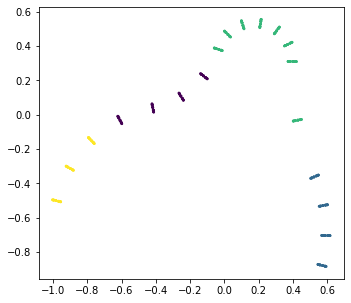

In [123]:
kmeans = KMeans(n_clusters=4).fit(data)
# print('kmeans.labels_ ' + str(kmeans.labels_))

# Verify that everything looks right
# ax = m3d.Axes3D(plt.figure())
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# print('x ' + str(x.min()) + ' ' + str(x.max()))
# print('y ' + str(y.min()) + ' ' + str(y.max()))
# print('z ' + str(z.min()) + ' ' + str(z.max()))
# ax.scatter3D(*data.T, c=kmeans.labels_)
# ax.set_xlim3d(-0.5, 0.5)
# ax.set_ylim3d(3.5, 4.5)
# ax.set_zlim3d(-2.1, -1.1)

# plt.scatter(x,y,c=kmeans.labels_, s=3)

# ax.scatter3D(*Z.T)
# print(str(Z.T))
plt.scatter(Z.T[0],Z.T[1],c=kmeans.labels_, s=3)
# ax.set_xlim3d(-0.5, 0.5)
# ax.set_ylim3d(-0.5, 0.5)
# ax.set_zlim3d(-0.5, 0.5)

# ax.plot3D(*linepts.T)
plt.rcParams['figure.figsize'] = [25, 5]
plt.axis('scaled')
plt.show()


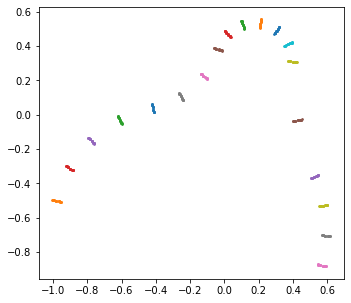

# of clusters 19


In [124]:
model = DBSCAN(eps=0.05, min_samples=9)

# fit model and predict clusters
yhat = model.fit_predict(data)

# retrieve unique clusters
clusters = unique(yhat)

x2 = Z.T[0]
y2 = Z.T[1]

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(x2[row_ix], y2[row_ix], s=3)
# show the plot
plt.rcParams['figure.figsize'] = [25, 5]
plt.axis('scaled')
plt.show()

# print('yhat ' + str(yhat))
# print('clusters ' + str(clusters))
print('# of clusters ' + str(clusters.size))

In [142]:
class Node:
    def __init__(self, p):
        self.p = p
        self.next = None
    
    def distance(self, other_node):
        return np.linalg.norm(self.p - other_node.p)


# Create nodes
nodes = list()
for cluster in clusters:
    row_ix = where(yhat == cluster)
    cluster_points = data[row_ix]
    node = Node(p=cluster_points.mean(axis=0))
    nodes.append(node)

# Find a continuous set of connected nodes
start = nodes.pop()
end = start
segments = []
while len(nodes) > 0:
    min_node = None
    min_dist = float('inf')
    closest_to_start = True

    for node in nodes:
        start_dist = start.distance(node)
        end_dist = end.distance(node)

        if start_dist < min_dist and start_dist <= end_dist:
            min_dist = start_dist
            min_node = node
            closest_to_start = True

        if end_dist < min_dist and end_dist < start_dist:
            min_dist = end_dist
            min_node = node
            closest_to_start = False
    
    if closest_to_start:
        min_node.next = start
        start = min_node    
    else:
        end.next = min_node
        end = min_node
        
    nodes.remove(min_node)

n = start
total_length = 0
while True:
    if n.next == None: 
        break
    total_length = total_length + n.distance(n.next)
    n = n.next

# Generate LED positions
LEDS_PER_METER = 60 # eg. 300LEDs/16.4ft
LED_DIST = 1 / LEDS_PER_METER
LED_START_OFFSET = 0.1 # 10cm offset from that start of a segment
LED_END_OFFSET = 0.1

segment_points = []
num_leds = math.floor((total_length - LED_START_OFFSET - LED_END_OFFSET) * LEDS_PER_METER)
dist = LED_START_OFFSET
fraction = 0
n = start
for i in range(num_leds):
    new_fraction = fraction + dist / n.distance(n.next)
    while new_fraction >= 1:
        # Move to next segment
        dist = dist - (1 - fraction) * n.distance(n.next)
        n = n.next
        fraction = 0
        new_fraction = dist / n.distance(n.next)

    fraction = new_fraction 
    np = n.p + fraction * (n.next.p - n.p)
    segment_points.append(np)

print('total length ' + str(segment_points))
print('linepts ' + str(linepts))


total length [array([-0.09900589,  2.50389095, -8.2951801 ]), array([-0.19801178,  2.4919173 , -8.28780004]), array([-0.2895566 ,  2.4580404 , -8.26691997]), array([-0.3763817 ,  2.42473431, -8.24639171]), array([-0.45102724,  2.37505397, -8.21577113]), array([-0.5126341 ,  2.33037528, -8.18823333]), array([-0.56622739,  2.27966398, -8.15697733]), array([-0.58716145,  2.2526379 , -8.14031977]), array([-0.60809551,  2.22561182, -8.12366221]), array([-0.62902956,  2.19858574, -8.10700464]), array([-0.64996362,  2.17155966, -8.09034708]), array([-0.67158125,  2.14493226, -8.07393524]), array([-0.68514628,  2.12870085, -8.06393098]), array([-0.6987113 ,  2.11246944, -8.05392672]), array([-0.71227633,  2.09623803, -8.04392247]), array([-0.72584136,  2.08000662, -8.03391821]), array([-0.73940639,  2.06377521, -8.02391395]), array([-0.75297141,  2.04754381, -8.01390969]), array([-0.76879501,  2.033272  , -8.00511323]), array([-0.77637614,  2.02886283, -8.00239563]), array([-0.78395727,  2.024

In [125]:
json_dict['led_segments'].append(
    {
        'uid': uid,
        'name': group.name,
        'num_leds': linepts.shape[0],
        'led_positions': linepts.tolist()
    })
uid = uid + 1